# Topic Modeling with Sklearn

### Topic Modeling이란?

+ 다수의 문서들로부터 공통적으로 내재되어 있는 주제들을 추출하기 위한 방법론

In [2]:
import csv
text = []
y = []

with open('movie_data_new.csv', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        #print(row)
        if row and len(row[0]) > 10: #review 길이가 10자 이상인 경우만
#        if row: #그 줄에 내용이 있는 경우에만
            text.append(row[0]) #영화 리뷰를 text 리스트에 추가
            y.append(row[2]) #영화이름을 text 리스트에 추가

In [3]:
print('리뷰 수:', len(text))
print('리뷰영화:', set(y))

리뷰 수: 12445
리뷰영화: {'범죄도시', '인피니티 워', '신과함께', '택시운전사', '코코', '곤지암', '라라랜드'}


In [4]:
text[:10]

['헐..다 죽었어....나중에 앤트맨 보다가도 깜놀...',
 '개연성은 무시해라 액션을 즐겨라 스타로드가 이끌어준다 각각의 영웅들을 즐겨라 그리고 단적인 신념이 얼마나 부질없는지 보셔라',
 '정말 지루할틈없이 넘잘만들었다 역시 대단하다',
 '마지막에 누구한테 연락한거지? 궁금',
 '다음 편이 궁굼해지네요^^',
 '안잼있는사람 있음???????????',
 '잘 만들었다! 지루할 틈이 없네...',
 '이제는 지겨워서 못보겠다',
 '롱턱 타노스의  장갑이 참 맘에 듬.  아이언 맨과 토르 닥터만 생고생하고..  가디언즈 오브 갤럭시 들 때문에  손해가 크다고 봄  들짐승 하고 칡뿌리 같은 캐릭이  재미를 더해줄줄 알았으나  아쉬움 . 분노의 상징 헐크가 겁을 먹다니..로키의 초반 출연뿐이 서운하지만  본 영화에 이어질 내용에 적합하지 않은지 서두에  죽는부분으로 마무리 됨은 심섬한 충격임 .  다음편에 헬라가 다시 나올까?',
 '와~~~~~진짜 개쪄는 인피니티워!!몇번을 봐도 개지린다.너무잼있다.어벤져스4도 너무 기대된다.빨리 2019년이왔으면 좋겠다.']

In [5]:
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twitter_tag = Okt()

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(tokenizer=twitter_tag.nouns, #우선은 명사만 사용
                      decode_error ='ignore', 
                      max_df=0.5, #너무 자주 나타나는 단어는 제외, 책에서는 0.15를 사용
                      #min_df = 3, #3개 미만의 문서에서 나타난 단어는 제외, 여기서는 max_features를 1000으로 제한하므로 별 필요 없음
                      max_features = 1000) #적당한 대상 단어 수를 선택
review_cv = vec.fit_transform(text)

In [6]:
review_cv.shape

(12445, 1000)

#### sklearn의 LatentDirichletAllocation을 이용하여 topic modeling 수행

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수를 지정
                                max_iter=25, #max_iter는 최종 모형에서는 5,000~10,000번 시도한다고 알려져 있음
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                #topic_word_prior: beta, doc_topic_prior: alpha
                                #일반적으로 beta는 0.1로 고정하고 alpha를 50/topic의 수 근처의 값을 시도
                                #alpha와 beta는 낮은 값을 사용할수록 특정 토픽들이 두드러지도록 하는 효과가 있다고 합
                                learning_method='batch', #'batch'는 'online'에 비해 더 성능이 좋고 느림, 현재는 default
                                n_jobs= -1, #사용 processor 수, None이면 1, -1이면 모두 사용
                                random_state=0)

review_topics = lda.fit_transform(review_cv)

In [8]:
print('topic-word distribution dimension:', lda.components_.shape)
print('document-topic distribution dimenstion', review_topics.shape)

topic-word distribution dimension: (10, 1000)
document-topic distribution dimenstion (12445, 10)


#### topic을 보기 쉽게 출력하는 함수를 작성

In [9]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()
    

In [10]:
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 좀, 느낌, 감독, 공포영화, 공포, 보기, 감, 소재, 나름, 소리
Topic #1: 더, 정말, 말, 다시, 음악, 한번, 사랑, 모두, 작품, 인생
Topic #2: 스토리, 내용, 마블, 부분, 만, 이해, 조금, 영상, 전개, 수준
Topic #3: 생각, 영화, 것, 수, 듯, 한국, 역시, 신, 대한, 내내
Topic #4: 그, 광주, 편, 역사, 우리, 가슴, 송강호, 노스, 택시, 다음
Topic #5: 연기, 배우, 최고, 마동석, 윤계상, 액션, 차태현, 함, 한국영, 연기력
Topic #6: 사람, 진짜, 그냥, 원작, 때, 안, 뭐, 신파, 거, 하나
Topic #7: 감동, 눈물, 재미, 마지막, 꼭, 보고, 가족, 처음, 끝, 추천
Topic #8: 시간, 볼, 내, 왜, 기대, 중간, 또, 나, 별로, 임
Topic #9: 영화, 점, 이, 돈, 평점, 관객, 중, 눈, 천만, 난



#### 한 자로 구성된 명사들은 의미파악이 어려우므로 삭제할 필요

In [11]:
twitter_tag.nouns(text[1])

['개연', '성은', '무시', '액션', '스타로드', '각각', '영웅', '적', '신념', '얼마나']

In [12]:
def tokenizer(str):
    return [token for token in twitter_tag.nouns(str) if len(token) > 1]

In [13]:
tokenizer(text[1])

['개연', '성은', '무시', '액션', '스타로드', '각각', '영웅', '신념', '얼마나']

#### 한 자로 된 단어를 제거하고 count vector 생성

In [14]:
#count vector 새로 생성
vec = CountVectorizer(tokenizer=tokenizer, decode_error ='ignore', 
                      max_df=0.5, max_features = 1000) #너무 자주 나타나는 단어는 제외
review_cv = vec.fit_transform(text)

In [15]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 50, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 영화, 공포, 머리, 노력, 때문, 폭력, 이름, 생각, 감동, 체험
Topic #1: 노스, 영화, 이상, 히어로, 결말, 상영, 지루함, 절대, 시간, 좀더
Topic #2: 마동석, 윤계상, 연기, 액션, 형사, 존재, 충격, 갑자기, 결말, 시각
Topic #3: 모두, 제대로, 진심, 누구, 배우, 김향기, 영화, 지금, 고생, 다가
Topic #4: 개인, 인간, 계속, 오늘, 영화, 세계, 그것, 해도, 사람, 그날
Topic #5: 영화, 매우, 사람, 어른, 또한, 걱정, 라이언, 결론, 요즘, 각색
Topic #6: 장면, 한국, 영화, 귀신, 가지, 생각, 헐리우드, 전달, 사진, 연말
Topic #7: 마블, 완전, 어벤져스, 대사, 시리즈, 인피니티, 줄거리, 오역, 짜증, 시간
Topic #8: 신파, 차태현, 액션, 눈물, 긴장감, 예상, 영화, 과거, 반드시, 예전
Topic #9: 보고, 추천, 영화, 가슴, 아들, 강추, 영화관, 가족, 학년, 추석
Topic #10: 영화, 무슨, 감동, 느낌, 등장, 기대, 정도, 리얼, 피아노, 그냥
Topic #11: 사랑, 인생, 이야기, 영화, 무엇, 완성, 비교, 도대체, 제목, 아무
Topic #12: 역시, 아이, 실망, 실화, 코믹, 효과, 영화, 스릴, 수작, 대안
Topic #13: 사람, 이해, 대한, 마지막, 뭔가, 편이, 토르, 만점, 영화, 이승
Topic #14: 스토리, 중간, 전개, 극장, 드라마, 전체, 정신, 화면, 짜임새, 연결
Topic #15: 현실, 주인공, 뮤지컬, 노래, 라면, 볼거리, 남자, 스톤, 시나리오, 이하
Topic #16: 영상, 내용, 처음, 조선족, 영화, 교훈, 감성, 눈물, 갈수록, 원래
Topic #17: 공포영화, 캐릭터, 아쉬움, 영화, 다큐, 상황, 누가, 다소, 외국, 타임
Topic #18: 영화, 이제, 보지, 강철, 댓글, 제일, 인정, 실감, 선택, 주제
Topic #19: 광주, 택시, 시민,

####  topic들을 대상으로 clustering을 수행해서 topic들이 잘 묶을 수 있는지 확인

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5) #5개 클러스터로 분류
kmeans.fit(lda.components_)

print('topic-word distribution dimension:', lda.components_.shape)
print('Cluster label:', kmeans.labels_)

topic-word distribution dimension: (50, 1000)
Cluster label: [0 1 3 1 1 0 0 1 1 0 0 1 1 1 4 1 1 1 0 2 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1
 1 1 1 1 1 1 0 0 0 1 1 1 1]


#### T-SNE를 이용하여 각 topic들 간의 관계를 시각화

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_review = tsne.fit_transform(lda.components_)
print('TSNE dimension:', tsne_review.shape)
tsne_review[:,0]

TSNE dimension: (50, 2)


array([  -6.949179  ,  -53.49401   , -156.57956   ,  -46.939014  ,
         56.485733  ,  -29.716232  , -125.482475  ,  136.42862   ,
        110.15663   , -117.80809   ,  -10.865295  ,    9.774828  ,
         74.02505   ,  -33.142303  ,   83.51573   ,  -87.200676  ,
        -92.081924  ,  -84.47544   ,  -19.687847  , -134.00212   ,
        122.0648    ,  133.9484    ,  -53.1566    ,   63.531685  ,
         28.457357  ,  -16.240503  ,  -59.76433   ,  -49.56166   ,
         14.863495  ,  -42.056747  ,  -97.79358   ,   14.14204   ,
        -62.900517  ,   79.143585  ,   42.47803   ,   58.135487  ,
         82.55377   ,   10.457184  ,   56.48281   ,  -41.110104  ,
         22.983059  ,   39.21739   ,   71.76845   ,   -0.75666666,
        -12.642868  ,  -33.12661   ,   10.020607  ,  -10.412574  ,
         22.035631  ,   42.73961   ], dtype=float32)

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib as mpl

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

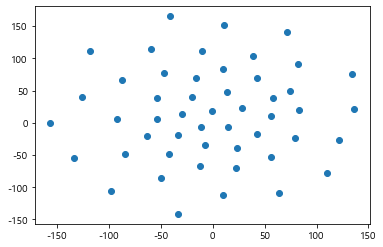

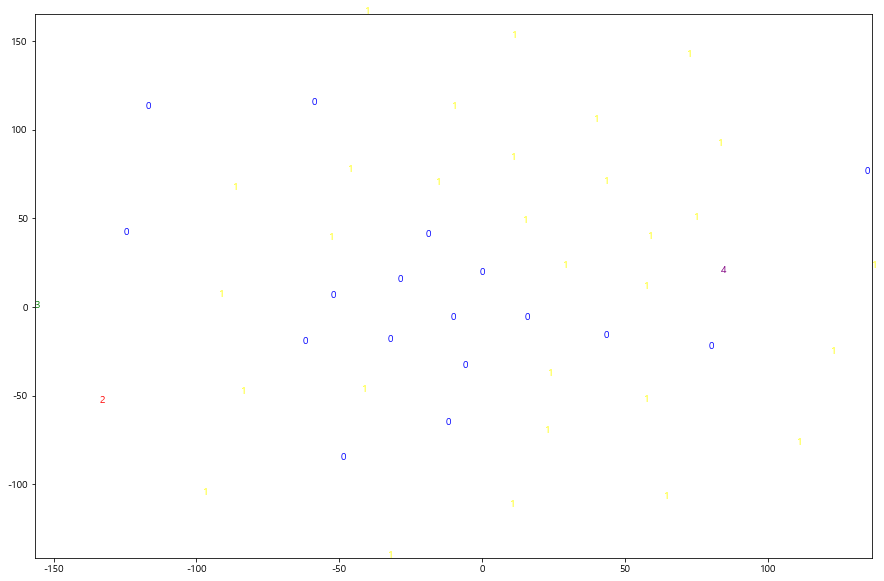

In [19]:
colors = {0:'blue', 1:'yellow', 2:'red', 3:'green', 4:'purple'}
x1 = tsne_review[:,0]
x2 = tsne_review[:,1]
plt.scatter(x1, x2)

plt.figure(figsize=(15,10))
plt.xlim(min(x1), max(x1))
plt.ylim(min(x2), max(x2))
for i in range(len(x1)):
#    plt.text(X1_lsi[i], X2_lsi[i], sample_label[i],
#            color = colors[sample_label[i]])
    plt.text(x1[i], x2[i], kmeans.labels_[i],
            color = colors[kmeans.labels_[i]])

#for word, pos in df.iterrows():
#    ax.annotate(word, pos, fontsize=30)
plt.show()



#### 최적의 결과를 찾기 위한 방법

+ 적절한 topic의 수는 perplexity 값을 이용해 찾음.
+ 낮을 수록 좋은 모형이나, 사람의 판단과 일치하지 않을 수 있음
+ 그 외에 alpha, beta는 앞서 설명한 바와 같이 beta=0.1로 고정하고 alpha를 50/토픽수 근처에서 찾아나감
+ 반복횟수는 5,000번 정도면 수렴

In [20]:
lda.perplexity(review_cv)

580.7734310430884

In [21]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 25, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=2.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)
lda.perplexity(review_cv)

Topic #0: 영화, 공포, 아주, 디즈니, 감동, 자극, 갈수록, 제발, 머리, 노력
Topic #1: 영화, 노스, 히어로, 다음, 지루함, 뮤지컬, 절대, 상영, 진짜, 스토리
Topic #2: 윤계상, 마동석, 연기, 영화, 액션, 악역, 형사, 배우, 존재, 평가
Topic #3: 하정우, 연기, 영화, 모두, 주지훈, 진심, 배우, 누구, 거의, 시대
Topic #4: 영화, 계속, 웃음, 세계, 감동, 개인, 우리, 사람, 해도, 오늘
Topic #5: 영화, 평점, 기억, 매우, 코코, 어른, 공감, 또한, 여기, 감동
Topic #6: 영화, 한국, 생각, 장면, 흥행, 가지, 여자, 스크린, 보고, 배우
Topic #7: 마블, 영화, 어벤져스, 완전, 시간, 대사, 시리즈, 부분, 사람, 진짜
Topic #8: 차태현, 영화, 신파, 눈물, 연기, 혼자, 진짜, 정말, 배우, 액션
Topic #9: 영화, 보고, 범죄, 아들, 추천, 연기, 정말, 도시, 연기자, 관람
Topic #10: 영화, 감동, 등장, 쓰레기, 천만, 느낌, 전반, 생각, 기대, 그냥
Topic #11: 사랑, 영화, 인생, 이야기, 음악, 최고, 완성, 마지막, 올해, 비교
Topic #12: 영화, 실망, 스토리, 그래픽, 감동, 재미, 아이, 실화, 개연, 초딩
Topic #13: 영화, 이해, 사람, 편이, 인간, 마지막, 토르, 감정, 진짜, 뭔가
Topic #14: 영화, 스토리, 중간, 전개, 화면, 구성, 전체, 극장, 드라마, 설정
Topic #15: 영화, 중국, 남자, 다만, 스톤, 볼거리, 노래, 현실, 시나리오, 유머
Topic #16: 영화, 내용, 교훈, 부모님, 배우, 조선족, 감성, 연기, 모든, 영상
Topic #17: 영화, 공포영화, 귀신, 약간, 다큐, 상황, 관객, 다소, 누가, 기술
Topic #18: 영화, 감독, 강철, 이제, 댓글, 제일, 알바, 웹툰, 인정, 그냥
Topic #19: 광주, 송강호, 택시, 시민, 역

557.823404029721

In [22]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 10, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)
lda.perplexity(review_cv)

Topic #0: 감동, 영화, 가족, 보기, 아이, 역시, 아주, 기억, 약간, 뭔가
Topic #1: 마블, 음악, 사랑, 영화, 노스, 현실, 결말, 다음, 주인공, 여운
Topic #2: 연기, 배우, 최고, 마동석, 윤계상, 액션, 연출, 연기력, 조연, 캐릭터
Topic #3: 광주, 역사, 우리, 가슴, 송강호, 모두, 마음, 택시, 지금, 내내
Topic #4: 스토리, 느낌, 영화, 이야기, 작품, 관객, 때문, 별로, 조금, 몰입
Topic #5: 그냥, 내용, 영화, 원작, 평점, 웹툰, 수준, 이해, 천만, 소재
Topic #6: 영화, 생각, 감독, 한국, 다시, 한번, 공포영화, 공포, 최악, 나름
Topic #7: 사람, 시간, 마지막, 장면, 정도, 부분, 인생, 완전, 영상, 이영화
Topic #8: 정말, 진짜, 눈물, 신파, 중간, 차태현, 한국영, 대박, 억지, 하정우
Topic #9: 영화, 보고, 재미, 기대, 처음, 추천, 이제, 영화관, 관람, 후회



412.2882740895663